In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)

def correlation(t, x, y):
    """The correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The sloppe of ther regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fit(table, x, y):
    """The height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def plot_residuals(t, x, y):
    """Plot a scatter diagram and residuals."""
    t.scatter(x, y, fit_line=True)
    actual = t.column(y)
    fitted = fit(t, x, y)
    residuals = actual - fitted
    print('r:', correlation(t, x, y))
    print('RMSE:', np.mean(residuals**2)**0.5)
    t.select(x).with_column('Residual', residuals).scatter(0, 1)

## Regression Model

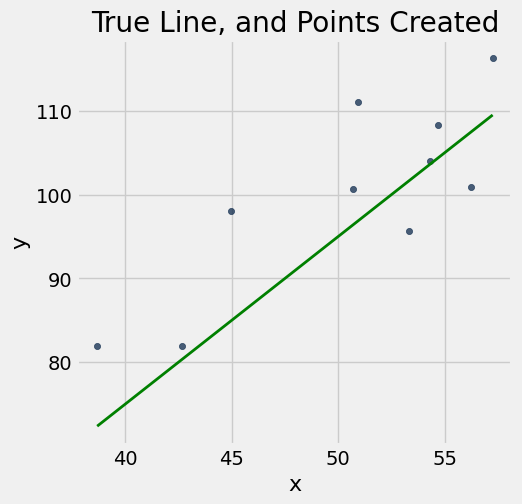

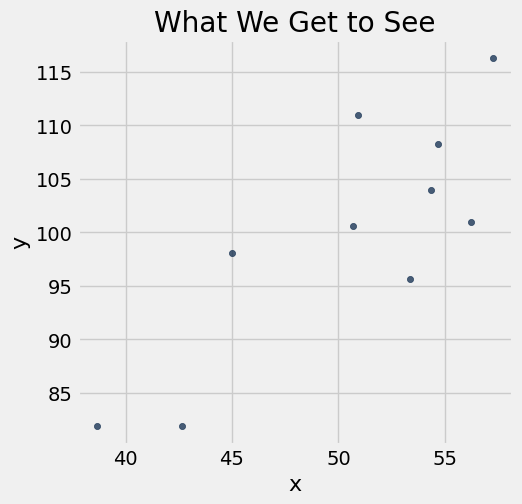

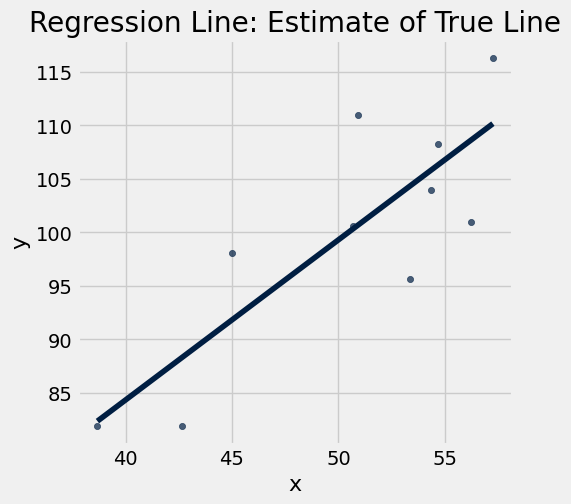

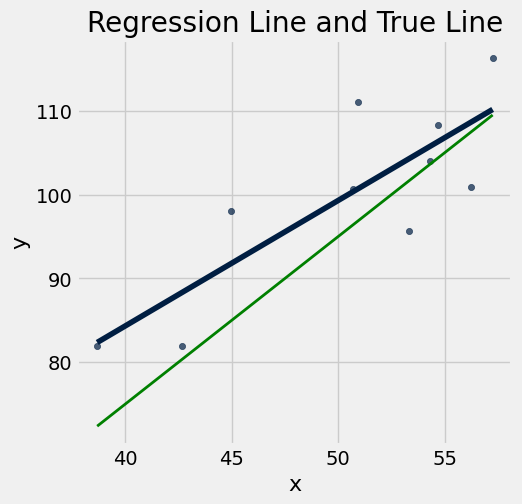

In [3]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)
    
    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')
    
    sample.scatter('x', 'y')
    plots.title('What We Get to See')
    
    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')
    
    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('Regression Line and True Line')
    
draw_and_compare(2, -5, 10)

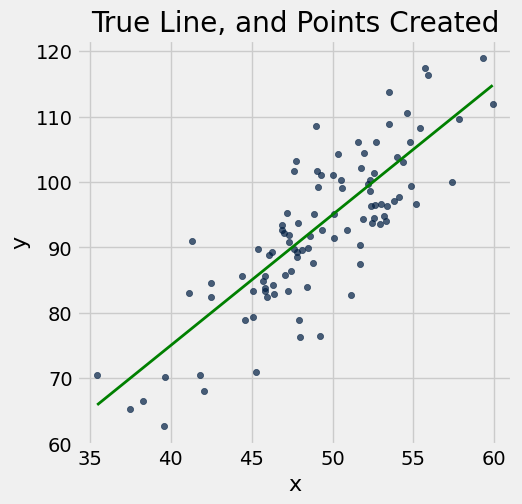

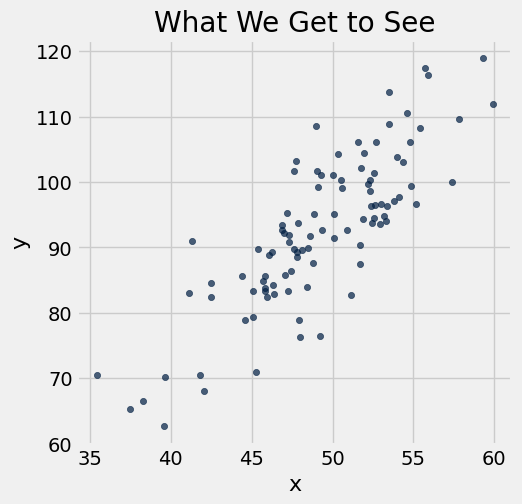

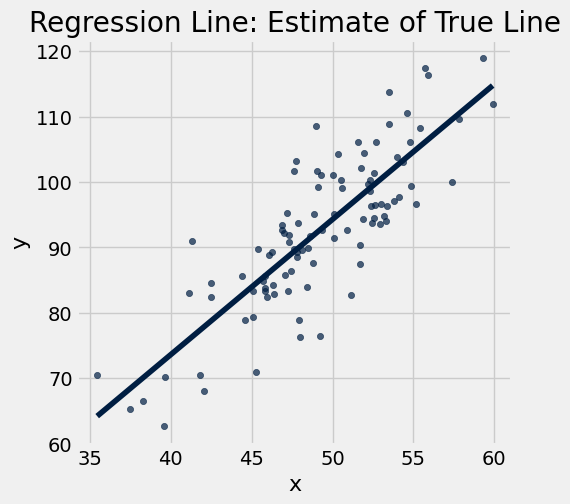

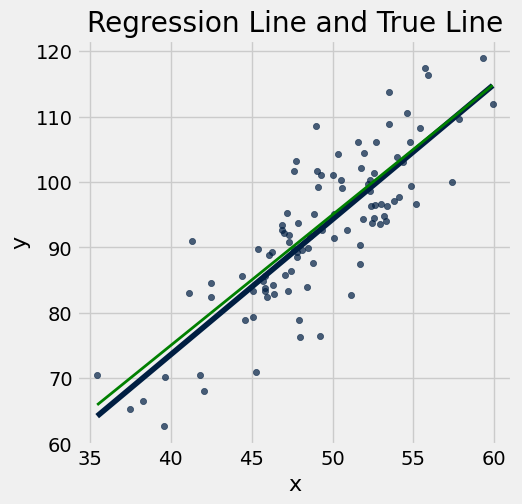

In [4]:
draw_and_compare(2, -5, 100)

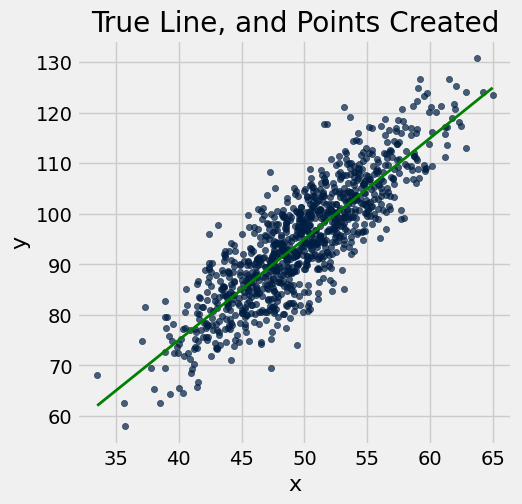

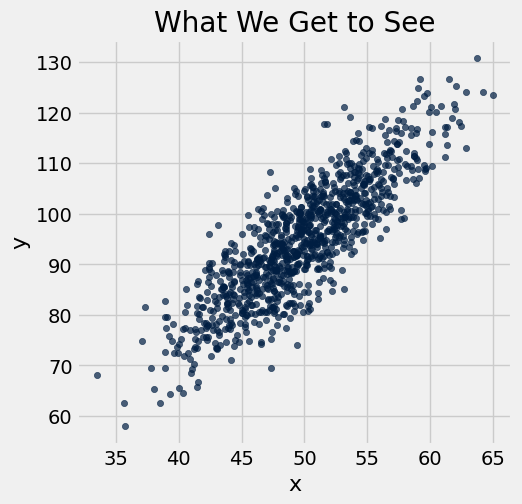

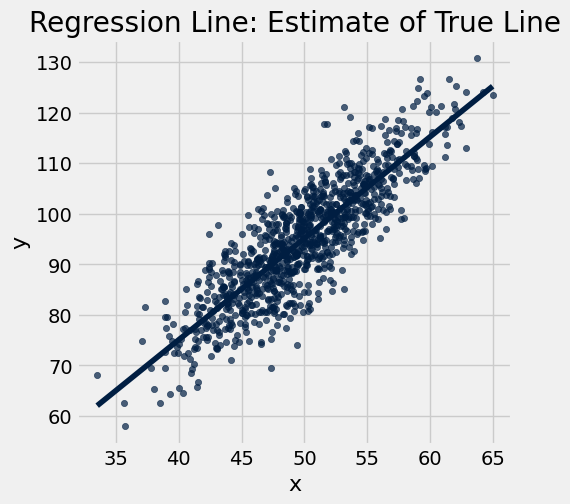

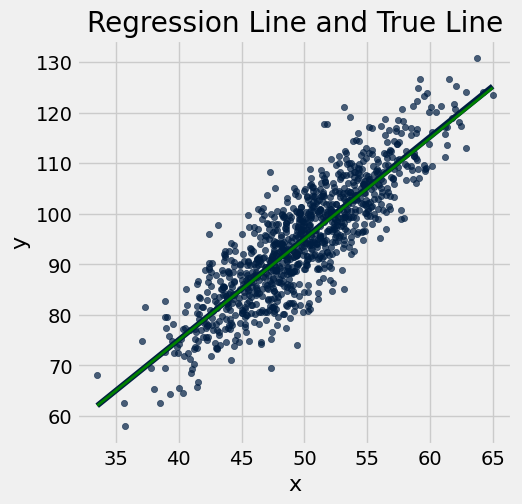

In [5]:
draw_and_compare(2, -5, 1000)

## Prediction Inference

In [6]:
baby = Table.read_table('baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


r: 0.407542793389
RMSE: 16.7303582567


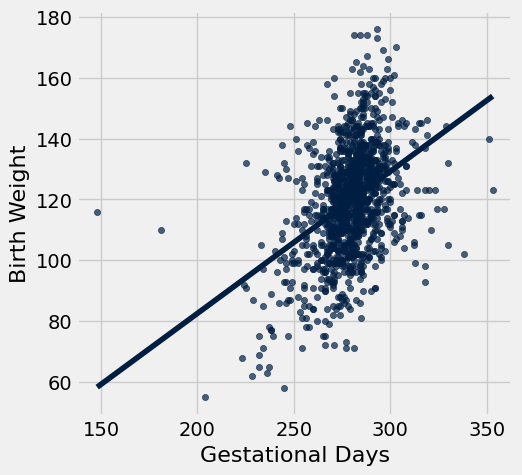

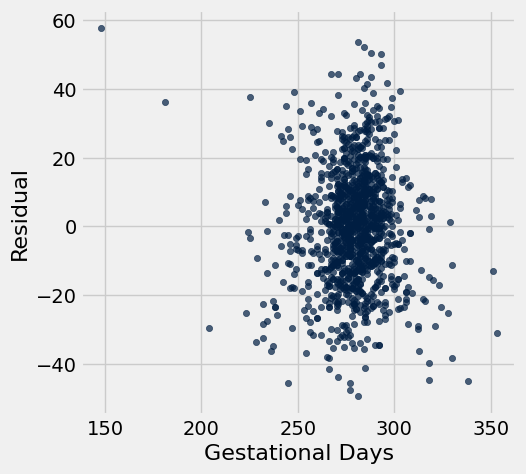

In [7]:
plot_residuals(baby, 'Gestational Days', 'Birth Weight')

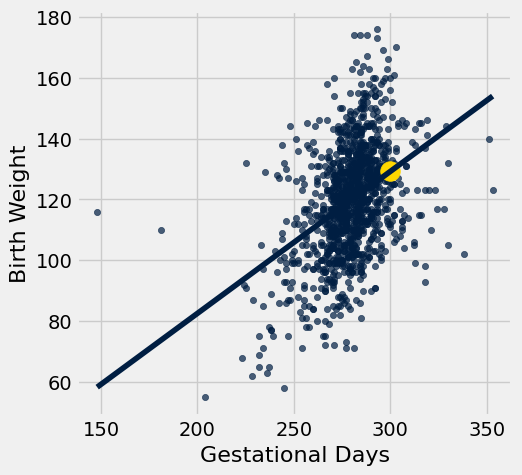

In [9]:
x = 300
a = slope(baby, 'Gestational Days', 'Birth Weight')
b = intercept(baby, 'Gestational Days', 'Birth Weight')
predicted_y = a * x + b

baby.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.scatter(300, predicted_y, color='gold', s=200)

In [11]:
predicted_y

129.2129241703143

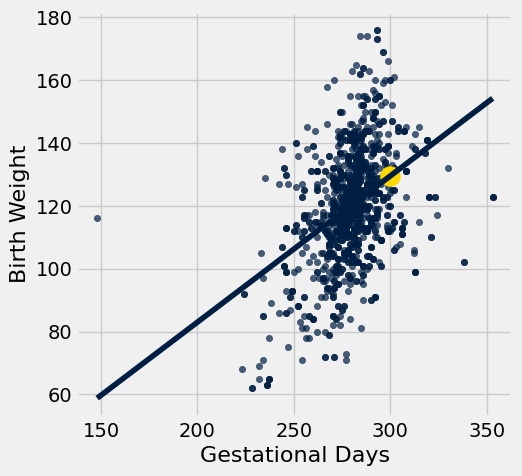

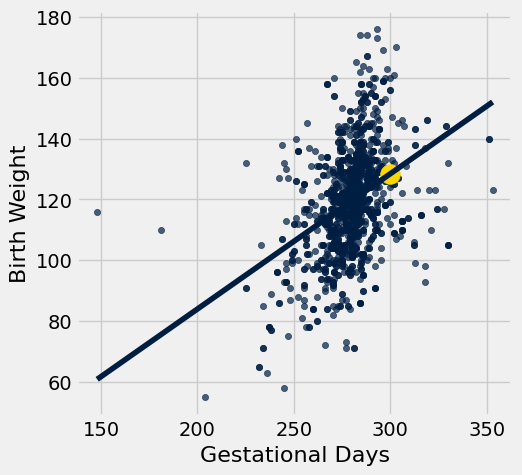

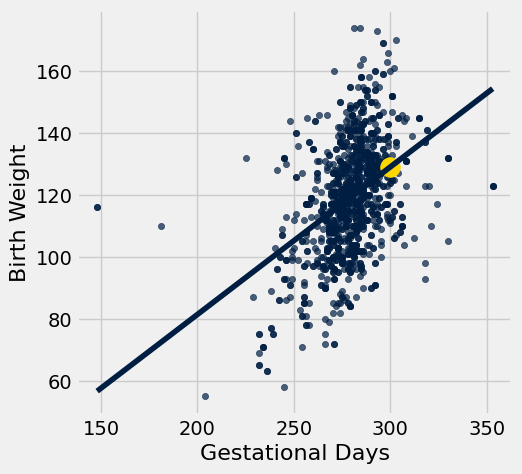

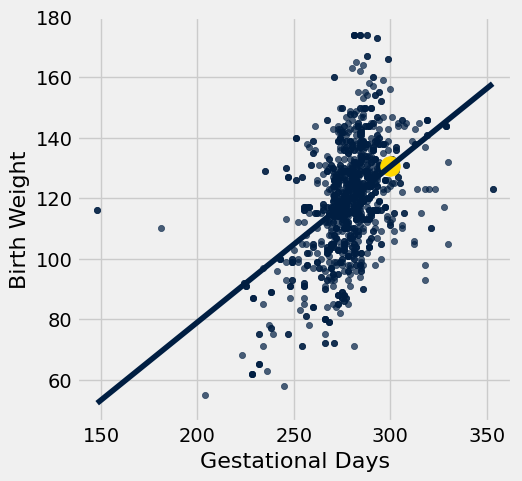

In [14]:
def prediction_at(t, x):
    a = slope(t, 'Gestational Days', 'Birth Weight')
    b = intercept(t, 'Gestational Days', 'Birth Weight')
    return a * x + b

for i in np.arange(4):
    resample = baby.sample()
    predicted_y = prediction_at(resample, 300)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=200)

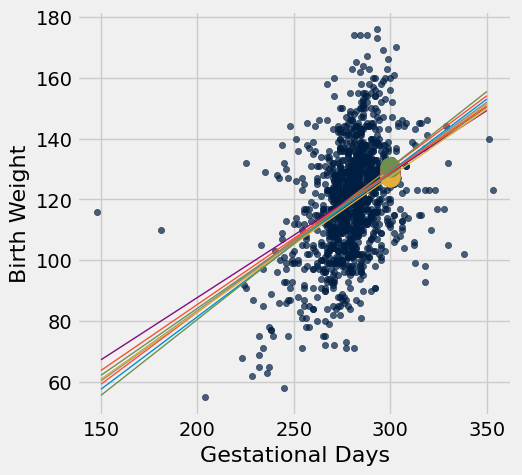

In [15]:
lines = Table(['slope', 'intercept', 'at 150', 'at 300', 'at 350'])

for i in range(10):
    resample = baby.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 150 + b, a * 300 + b, a * 350 + b])
    
baby.scatter('Gestational Days', 'Birth Weight')
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([150, 350], [line.item('at 150'), line.item('at 350')], lw=1)
    plots.scatter(300, line.item('at 300'), s=200)

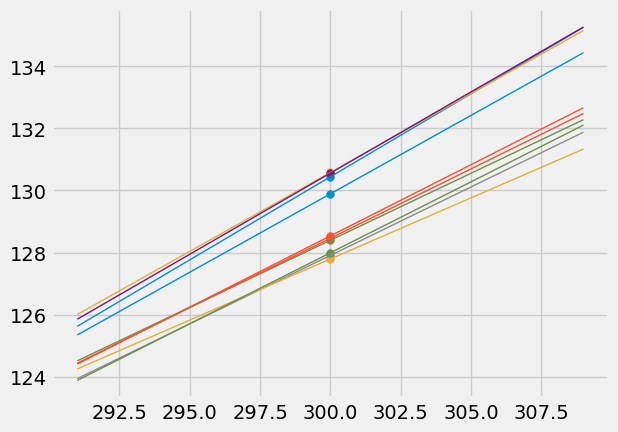

In [16]:
lines = Table(['slope', 'intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = baby.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])
    
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30)

Approximate 95%-confidence interval of regression height:
127.284621802 131.280231853 (width = 3.99561005102 )


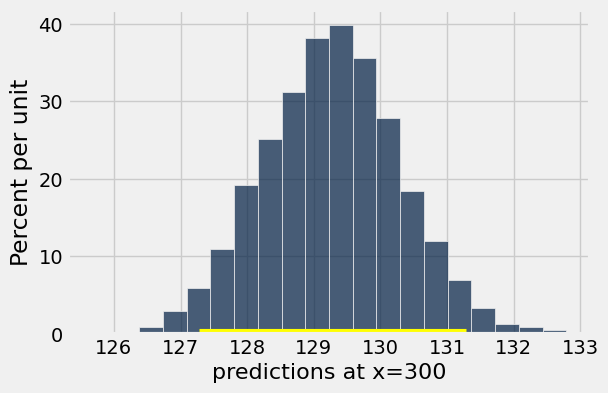

In [17]:
def bootstrap_prediction(table, x, y, new_x, repetitions=5000):
    
    # Bootstrap resampling
    predictions = []
    for i in np.arange(repetitions):
        resample = table.sample()
        a = slope(resample, x, y)
        b = intercept(resample, x, y)
        predicted_y = a * new_x + b
        predictions.append(predicted_y)
        
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval of regression height:')
    print(left, right, '(width =', right - left, ')')
    
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 300)

Approximate 95%-confidence interval of regression height:
138.978913274 147.943100256 (width = 8.96418698199 )


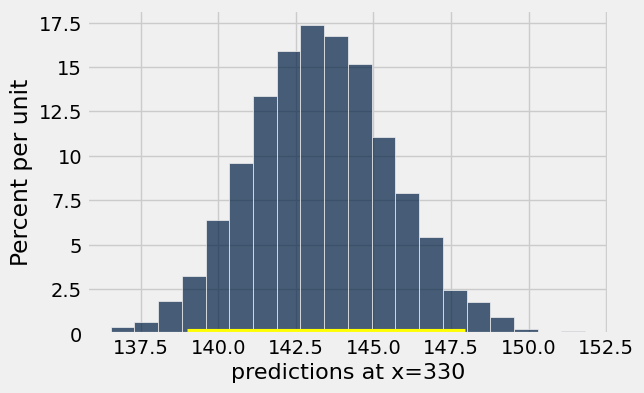

In [18]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 330)

Approximate 95%-confidence interval of regression height:
118.913759741 120.857740198 (width = 1.943980457 )


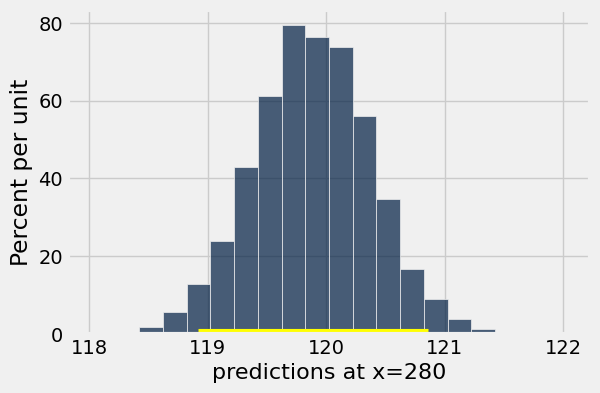

In [19]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 280)

In [ ]:
## 